# What is an Active User?

We are often interested in how many users there are at an account. This might be used when detemining how much software they need or determining software splits for commissions. In the past we have taken the approach of counting distinct user names from phone home data without regards to the level of use by users.

It seems clear that this system has weaknesses including:

1. some very casual users (maybe an IT person installing the software) get counted just as much as a person using the software every day.
2. some users take a training course or install the software but then never use it.
3. users travel to different locations and use a license while they are there and therefore get counted at multiple sites

While we can't address these issues perfectly we can make progress. The first thing to do is look at things weekly rather than over a quarter or a year. By looking at use on a weekly basis the impact of the problems are reduced. The other thing we can do is ignore some usage, for example, sessions that last less than a certain time.  We can also ignore users that run the software below a threshold, for example the number of starts per week.

This analysis varies these parameters to see what the impact is on the results. For this analysis we will look at some Qorvo data, specifically the use of all licenses for accounts 8905, 991 and 6706 over the period of 2017-09-03 to 2018-03-11.

We will plot the number of unique user names we see per week that match the criteria we specify.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dtutil.util import init_cdb
from dtutil.sqltools import query_to_dataframe
import pylab
pylab.rcParams['figure.figsize'] = (12,8)

In [2]:
msql_conn = init_cdb()
cursor = msql_conn.cursor()

In [3]:
start_date = "2017-09-03"
end_date = "2018-03-11"

In [9]:
def get_query(start, end, min_time, min_starts):
    return """
with cte as (
select cast(contract_num as varchar) as sn
from nxscontr 
where contract_type='LICENSE' 
	and effect_end >= '{0}'
	and cust_code in ('8905', '991', '6706')
)
, starts_per_week as (
select user_name, 100 * (DATEPART(year, s.log_date) - 2010) + DATEPART(week, s.log_date) as week, count(*) as starts
from lds_starts as s with(nolock)
	inner join lds_stop as e on s.instid = e.instid
where
	s.log_date between '{0}' and '{1}'
	and e.log_date > '{0}'
	and e.uptime > {2}
	and s.serial_num in (select sn from cte)
group by user_name, 100 * (DATEPART(year, s.log_date) - 2010) + DATEPART(week, s.log_date)
having count(*) >= {3}
)
select week, count(user_name) as ws{3}_mt{2}
from starts_per_week
group by week
""".format(start, end, min_time, min_starts)

In [41]:
df1 = query_to_dataframe(cursor, get_query(start_date, end_date, 120, 3))
df2 = query_to_dataframe(cursor, get_query(start_date, end_date, 120, 1))
df3 = query_to_dataframe(cursor, get_query(start_date, end_date, 300, 1))
df4 = query_to_dataframe(cursor, get_query(start_date, end_date, 300, 3))

In [42]:
df = pd.merge(df1, df2, on='week')
df = pd.merge(df, df3, on='week')
df = pd.merge(df, df4, on='week')

In [43]:
df5 = query_to_dataframe(cursor, get_query(start_date, end_date, 1, 1))
df6 = query_to_dataframe(cursor, get_query(start_date, end_date, 1, 3))

In [44]:
df = pd.merge(df, df5, on='week')
df = pd.merge(df, df6, on='week')

In [45]:
df7 = query_to_dataframe(cursor, get_query(start_date, end_date, 1, 2))
df8 = query_to_dataframe(cursor, get_query(start_date, end_date, 120, 2))
df9 = query_to_dataframe(cursor, get_query(start_date, end_date, 300, 2))
df = pd.merge(df, df7, on='week')
df = pd.merge(df, df8, on='week')
df = pd.merge(df, df9, on='week')

### Impact of Minimum Session Time

Here we will look at the impact on the number of users per week when we ignore sessions that last less than a time threshold.  For this we will look at a 1 second, 2 minute and 5 minute threshold.

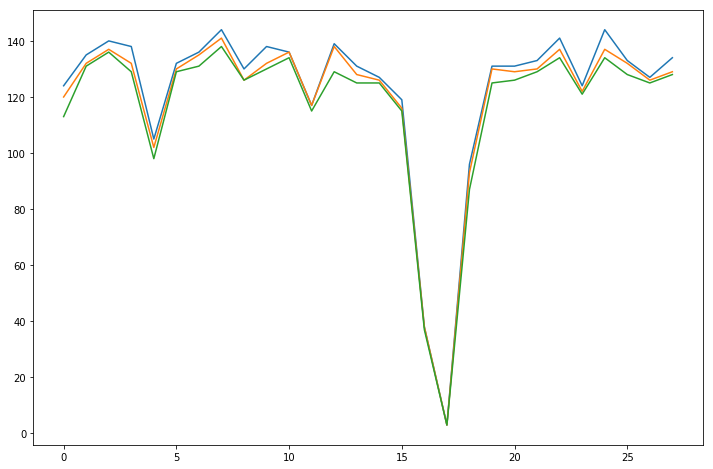

In [46]:
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.plot(df[['ws1_mt1', 'ws1_mt120', 'ws1_mt300']])
plt.show()

From this we definitely see a drop in the user counts when we ignore sessions of less than 2 or 5 minutes. Given how little work you can get done in MWO in less than 5 minutes I consider the lower curve above (ignoring sessions less than 5 minutes) to be a more realistic user count.

### Impact of Minumum Starts Per Week

In the same way we can choose to not count users that start the software less than a certain number of times per week.  He we plot that for 1, 2 and 3 starts per week.

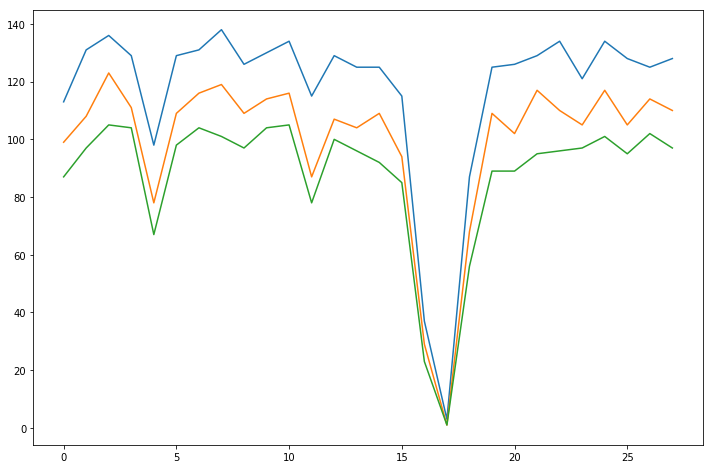

In [47]:
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.plot(df[['ws1_mt300', 'ws2_mt300', 'ws3_mt300']])
plt.show()

We see this has a much larger impact. Only 73% of the people that use AWR in a given week start it 3 times per week. This is rather surprising to me given the way I work but in looking at user data there are many users that start a session of MWO and keep it running for very long periods of time. Given that we have already selected to ignore sessions with durations of less than 5 minutes I suggest that we do not limit our user count by the number of starts per week (use the blue curve above).

### Raw Data Below

In [50]:
df

,week,ws3_mt120,ws1_mt120,ws1_mt300,ws3_mt300,ws1_mt1,ws3_mt1,ws2_mt1,ws2_mt120,ws2_mt300
0,736,89,120,113,87,124,94,111,106,99
1,737,101,132,131,97,135,104,115,112,108
2,738,110,137,136,105,140,117,126,124,123
3,739,105,132,129,104,138,112,117,116,111
4,740,71,102,98,67,105,74,80,79,78
5,741,99,130,129,98,132,107,121,112,109
6,742,107,135,131,104,136,113,120,117,116
7,743,107,141,138,101,144,114,130,122,119
8,744,100,126,126,97,130,106,119,114,109
9,745,105,132,130,104,138,113,123,118,114
